In [46]:
# Importing the necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
from os import listdir
from matplotlib import image
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Loading the images using the ImageDatagenerator class

In [47]:
data_dir = 'E:\\Final_Project\\Model\\dataset'

In [48]:
generator = ImageDataGenerator(rescale=1./255)

In [49]:
#Specifying how the ImageDataGenerator will read and deliver images
Image_generator = generator.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='binary')

Found 485 images belonging to 2 classes.


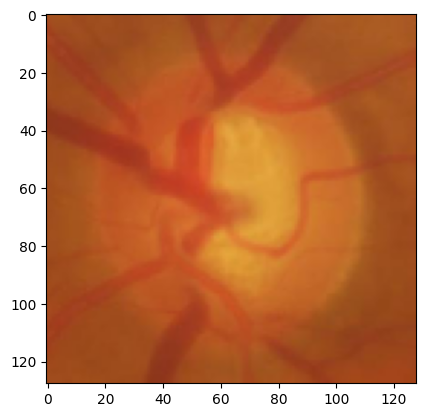

0.0


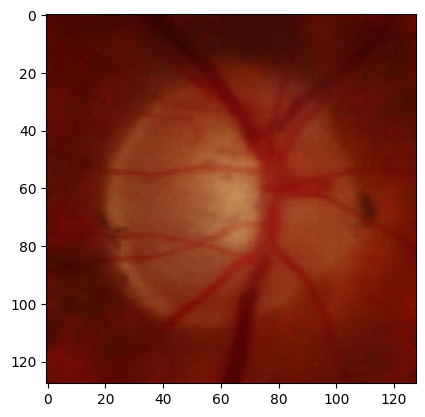

0.0


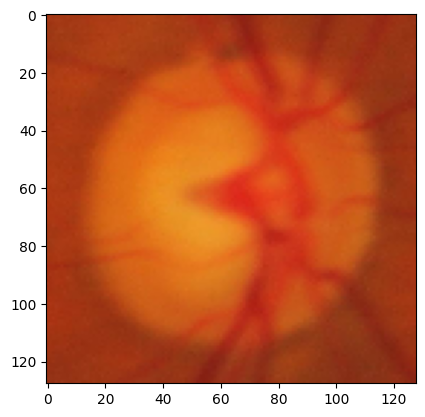

0.0


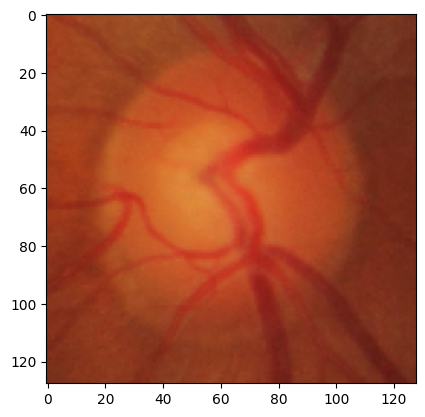

1.0


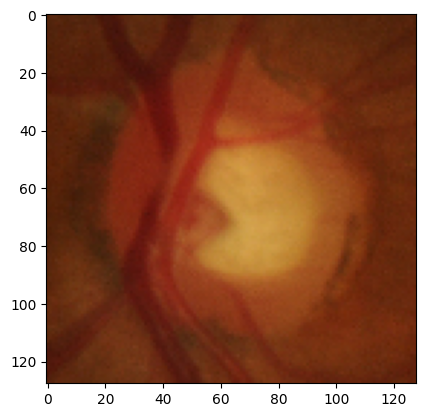

0.0


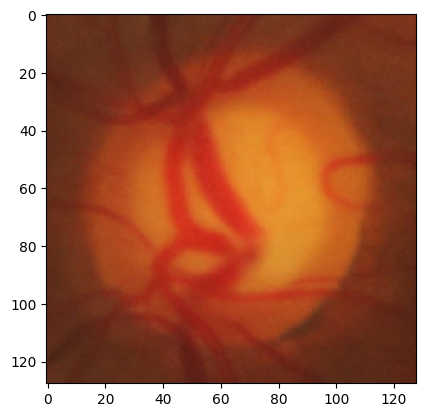

0.0


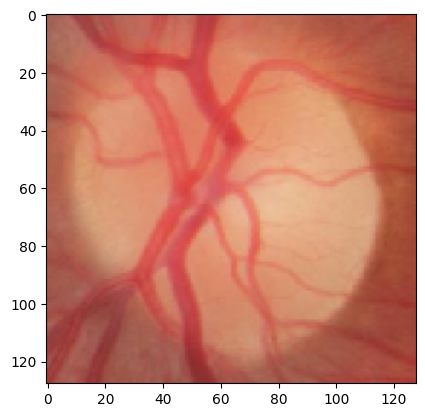

1.0


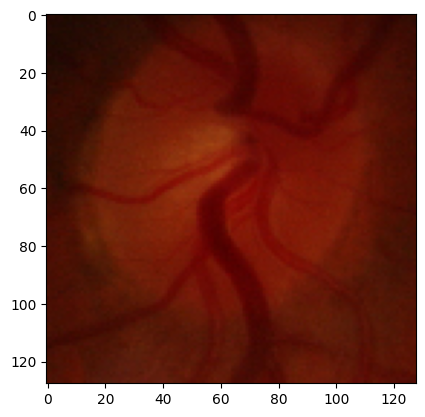

1.0


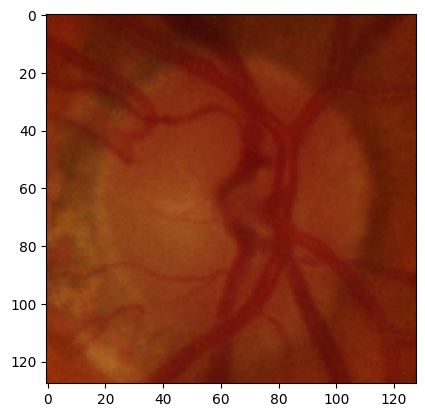

1.0


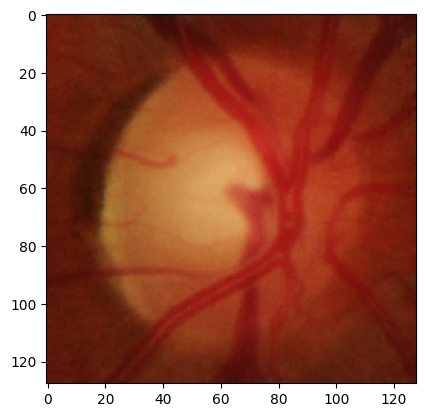

1.0


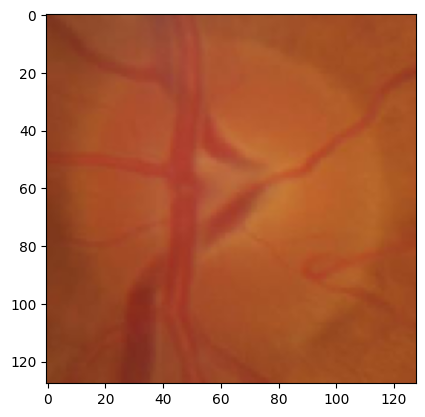

1.0


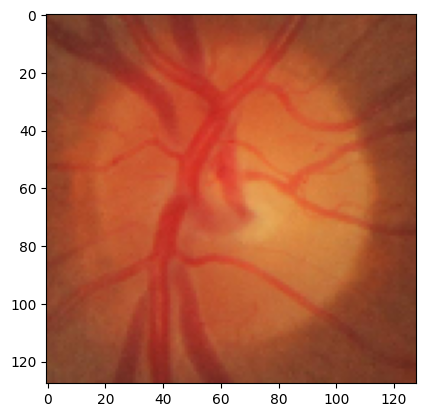

1.0


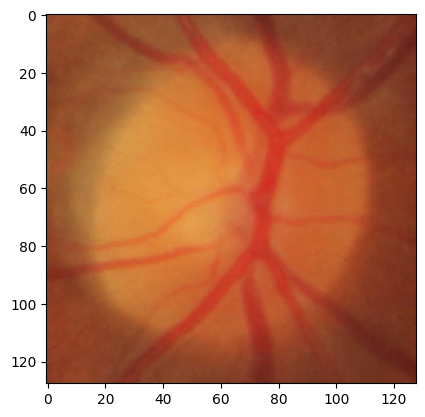

1.0


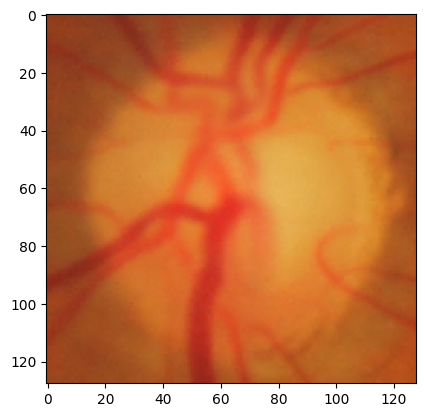

0.0


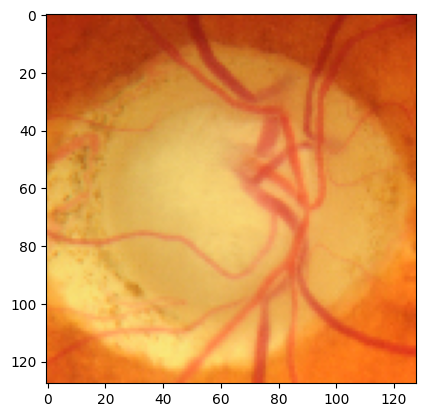

0.0


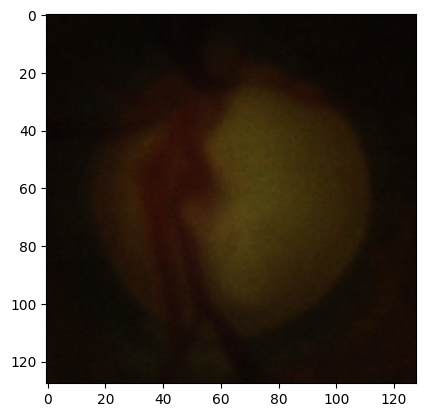

0.0


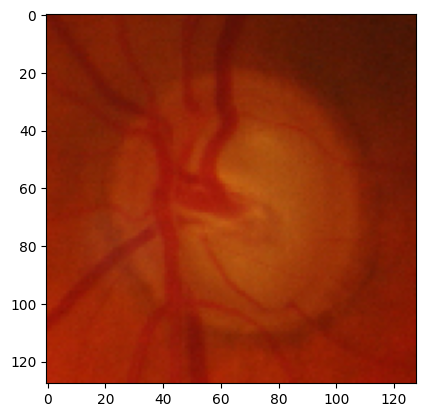

0.0


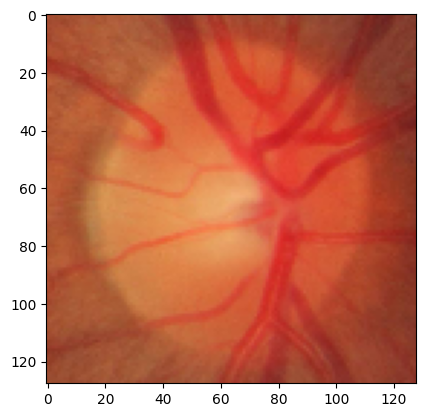

1.0


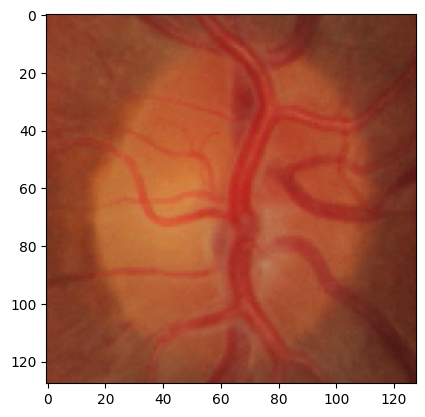

1.0


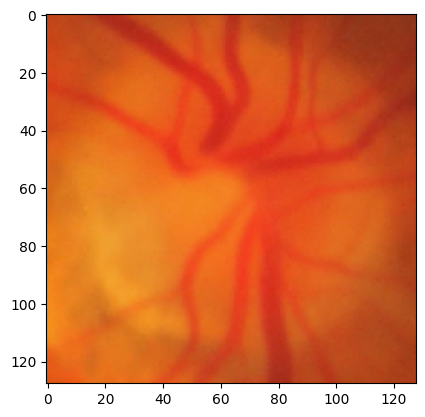

1.0


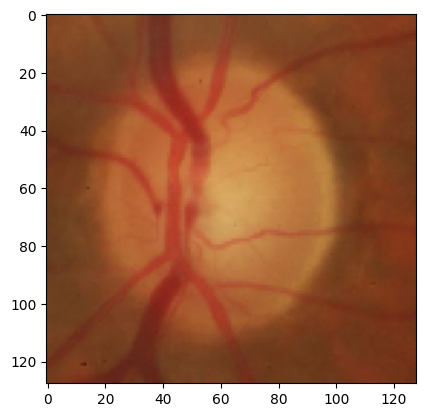

1.0


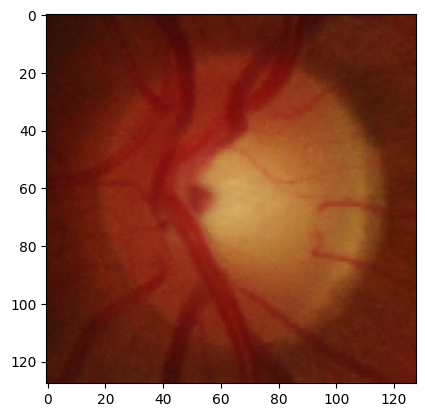

1.0


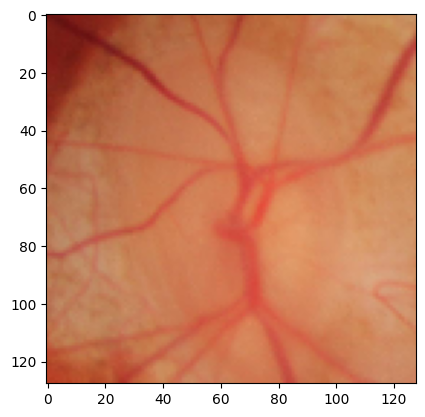

0.0


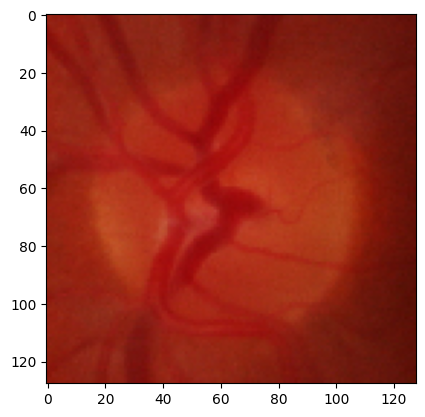

1.0


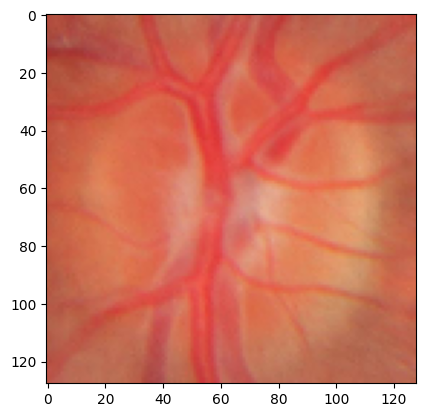

1.0


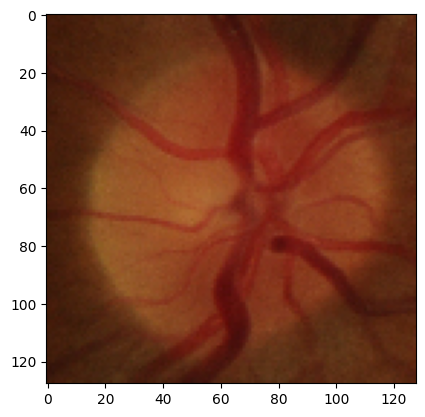

1.0


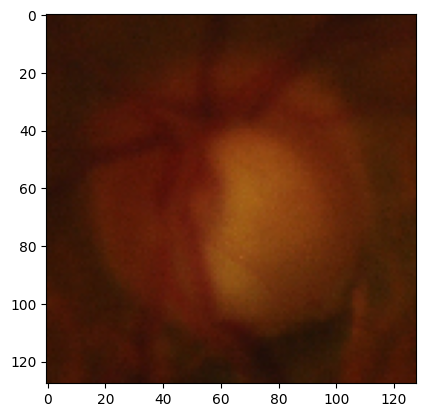

0.0


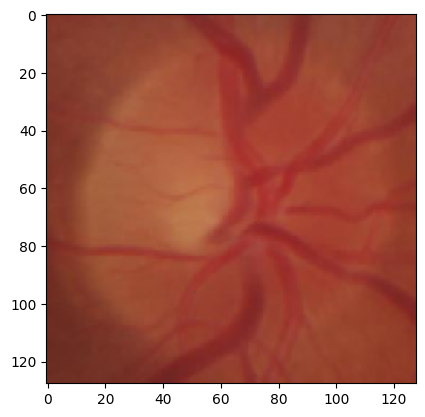

1.0


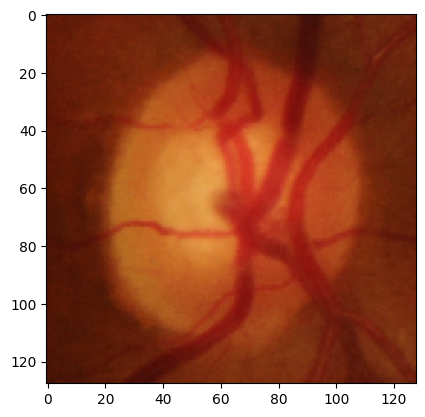

0.0


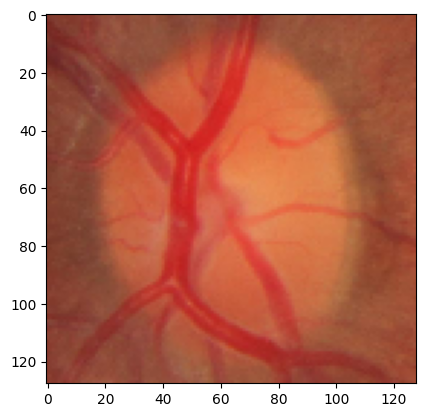

1.0


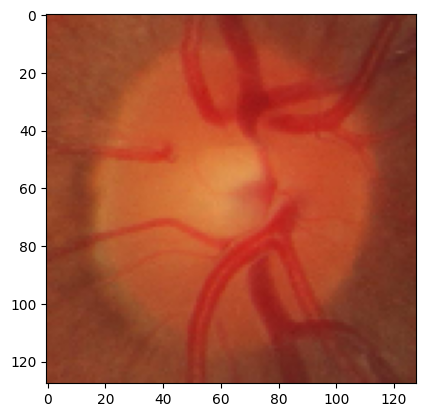

1.0


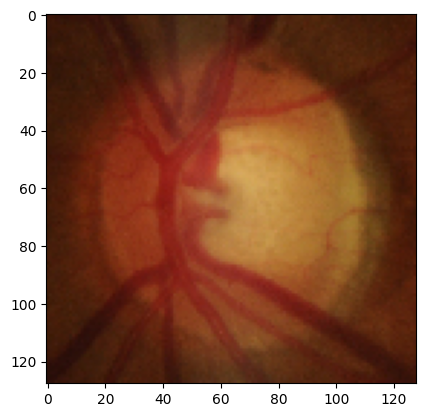

1.0


In [50]:
counter = 0
for images, labels in Image_generator:
    # my_batch is a tuple with images and labels
    for i, label in enumerate(labels):
        # Gives one image and its corresponding label
        plt.imshow(images[i])
        plt.show()
        print(label)
        counter += 1
    if counter >= len(Image_generator):
        break


# Image Augmentation

In [51]:
# Image Augmentation
Augmented_generator = ImageDataGenerator(
    rotation_range=30, # Rotate the image randomly up to 30 degrees
    width_shift_range=12, # Shift the image randomly up to 12 pixels horizontally
    height_shift_range=12, # Shift the image randomly up to 12 pixels vertically
    shear_range=(0.2), # Apply shear transformation to the image
    zoom_range=[0.8, 1.2], # Apply random zoom between 0.8 to 1.2
    horizontal_flip=True, # Flip the image horizontally
    vertical_flip=True, # Flip the image vertically
    rescale=1./255, # Rescale pixel values from [0, 255] to [0, 1]
    fill_mode='nearest' # Fill in any newly created pixels due to augmentation using the nearest value
)

In [59]:
# Set the batch size for the training data
batch_size = 48

# Use the flow_from_directory method to generate batches of image data from a directory
train_generator = Augmented_generator.flow_from_directory(
        data_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')


num_batches = len(train_generator)
print('Number of batches: ', num_batches)

images_per_batch = train_generator.batch_size
print('Images per batch: ', images_per_batch)

num_classes = train_generator.num_classes
print("Number of classes: ", num_classes)

total_images = num_batches * images_per_batch
print("Total number of images: ", total_images)
processed_images = []  # Store the processed images
labels = []  # Store the corresponding labels

Found 485 images belonging to 2 classes.
Number of batches:  11
Images per batch:  48
Number of classes:  2
Total number of images:  528


# Data Preprocessing

In [60]:

def process_images_batch(batch_images, batch_labels):

    for i in range(len(batch_images)):
        gray_img = cv2.cvtColor(batch_images[i], cv2.COLOR_BGR2GRAY)
        gray_img = cv2.bilateralFilter(gray_img, 9, 75, 75)

        # Normalize the grayscale image
        normalized_img = cv2.normalize(gray_img, None, 0, 255, cv2.NORM_MINMAX)
        normalized_img = normalized_img.astype('uint8')

        # Apply CLAHE to the normalized and denoised grayscale image
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(normalized_img)

        # Convert the CLAHE-enhanced image from grayscale to RGB
        clahe_rgb_img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)

        # Append the CLAHE-enhanced and RGB image to the processed_images list
        processed_images.append(clahe_rgb_img)
        labels.append(batch_labels[i])  # Append the corresponding label

    return processed_images, labels


In [61]:
def generate_processed_batches(train_generator, batch_size):
    for batch_images, batch_labels in train_generator:
        num_images = len(batch_images)
        num_batches = int(np.ceil(num_images / batch_size))

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, num_images)
            batch = batch_images[start_idx:end_idx]

            batch_processed_images, batch_labels = process_images_batch(batch, batch_labels[start_idx:end_idx])

            yield batch_processed_images, batch_labels

            # Clear the processed_images and labels lists
            del batch_processed_images
            del batch_labels

In [62]:
counter = 0
batch_size = 48

# Generate processed image batches
processed_batches_generator = generate_processed_batches(train_generator, batch_size)

# Process the images
for batch_processed_images, batch_labels in processed_batches_generator:
    processed_images.extend(batch_processed_images)
    labels.extend(batch_labels)

    counter += len(batch_processed_images)

    if counter >= total_images:
        break

processed_images = np.array(processed_images)
labels = np.array(labels)

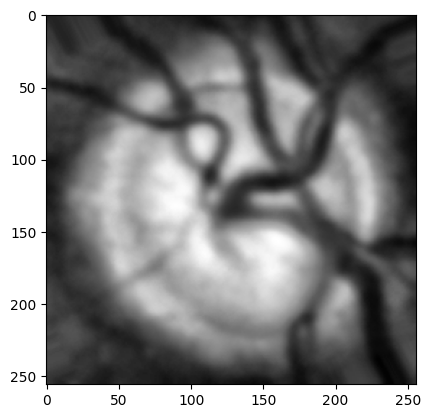

[1. 0.]


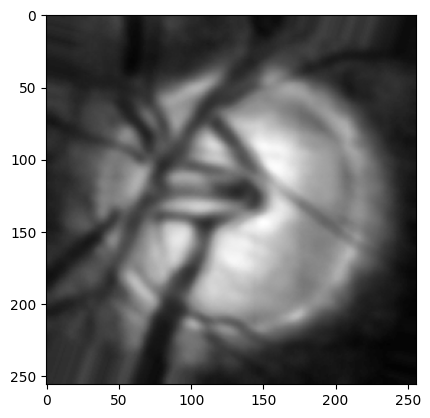

[1. 0.]


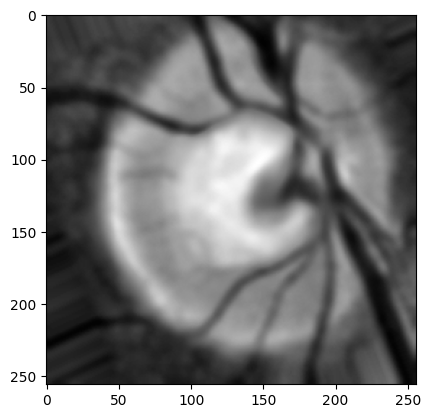

[0. 1.]


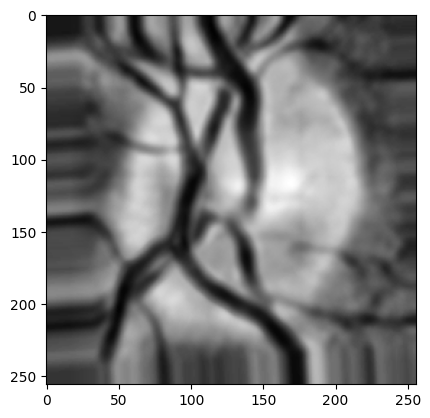

[0. 1.]


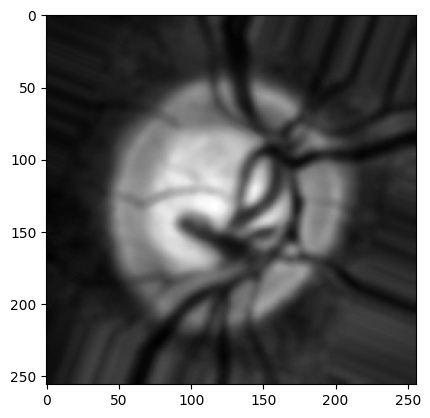

[1. 0.]


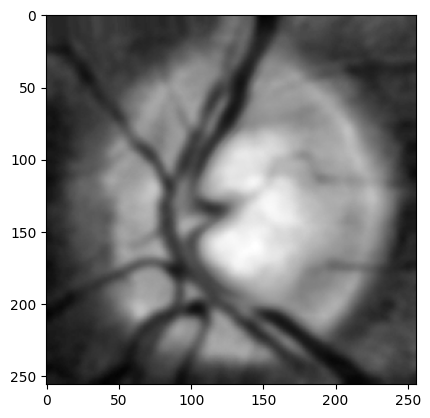

[1. 0.]


In [63]:
# Display the batch of processed images and corresponding labels
for i, img in enumerate(processed_images):
    plt.imshow(img)
    plt.show()
    print(labels[i])

    if i == 5:
        break
        

# Feature Extraction

In [68]:
processed_images = np.array(processed_images)
#print('processed_images: ', len(processed_images))
num_samples = processed_images.shape[0]
#print('Samples: ', num_samples)
height, width = processed_images.shape[1:3]
channels = processed_images.shape[3] if len(processed_images.shape) == 4 else 1

processed_images = processed_images.reshape(num_samples, height, width, channels)

scaler = StandardScaler()
normalized_features = scaler.fit_transform(processed_images.reshape(-1, height * width * channels))

normalized_features = normalized_features.reshape(num_samples, height, width, channels)
print("Shape of normalized features: ",normalized_features.shape)
print("Total Processed Images: ", num_samples)


Shape of normalized features:  (672, 256, 256, 3)
Total Processed Images:  672


# Splitting data

In [69]:
from sklearn.model_selection import KFold
# Split the normalized features and labels into 60% training, 20% validation, and 20% testing sets
X = normalized_features
y = labels
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Split the training set into 60% training and 20% validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(X_train.shape)

(403, 256, 256, 3)


# Model Definition

In [84]:
# Define the input shape for the CNN model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [89]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name = '0_Blk1_Conv1', input_shape=input_shape))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name = '1_Blk2_Conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name = '3_Blk1_Pool'))
#model.add(Dropout(0.25, name = '3_Blk1_Dropout'))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name = '2_Blk2_Conv1'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name = '3_Blk2_Conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name = '4_Blk2_Pool'))
#model.add(Dropout(0.25, name = '6_Blk2_Dropout'))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name = '5_Blk3_Conv1'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name = '6_Blk2_Conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name = '7_Blk3_Pool'))
model.add(Dropout(0.25, name = '8_Blk3_Dropout'))

model.add(Flatten(name = '9_Blks_Flatten'))
model.add(Dense(units=128, activation='relu', name = '10_Blks_FC'))
model.add(Dropout(0.5, name = '11_Blks_Dropout'))
model.add(Dense(units=2, activation='sigmoid', name = '11_Output'))

In [90]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_Blk1_Conv1 (Conv2D)       (None, 254, 254, 64)      1792      
                                                                 
 1_Blk2_Conv2 (Conv2D)       (None, 252, 252, 64)      36928     
                                                                 
 3_Blk1_Pool (MaxPooling2D)  (None, 126, 126, 64)      0         
                                                                 
 2_Blk2_Conv1 (Conv2D)       (None, 124, 124, 64)      36928     
                                                                 
 3_Blk2_Conv2 (Conv2D)       (None, 122, 122, 64)      36928     
                                                                 
 4_Blk2_Pool (MaxPooling2D)  (None, 61, 61, 64)        0         
                                                                 
 5_Blk3_Conv1 (Conv2D)       (None, 59, 59, 128)      

In [91]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Train the model on the training set
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))#87 epochs

Epoch 1/25
13/13 [==============================] - 85s 7s/step - loss: 0.8056 - accuracy: 0.5459 - mse: 0.2643 - val_loss: 0.6645 - val_accuracy: 0.7037 - val_mse: 0.2357
Epoch 2/25
13/13 [==============================] - 84s 6s/step - loss: 0.5505 - accuracy: 0.7667 - mse: 0.1857 - val_loss: 0.4917 - val_accuracy: 0.7259 - val_mse: 0.1659
Epoch 3/25
13/13 [==============================] - 88s 7s/step - loss: 0.3857 - accuracy: 0.8412 - mse: 0.1214 - val_loss: 0.3399 - val_accuracy: 0.9037 - val_mse: 0.0996
Epoch 4/25
13/13 [==============================] - 92s 7s/step - loss: 0.2212 - accuracy: 0.9256 - mse: 0.0645 - val_loss: 0.1854 - val_accuracy: 0.9556 - val_mse: 0.0448
Epoch 5/25
13/13 [==============================] - 93s 7s/step - loss: 0.1562 - accuracy: 0.9529 - mse: 0.0427 - val_loss: 0.2271 - val_accuracy: 0.9630 - val_mse: 0.0378
Epoch 6/25
13/13 [==============================] - 96s 7s/step - loss: 0.0525 - accuracy: 0.9826 - mse: 0.0157 - val_loss: 0.1517 - val_acc

# Evaluation

In [92]:
from sklearn.metrics import roc_auc_score
# Evaluate the model on the testing set
y_pred = model.predict(X_test)
# Evaluate the model on the testing set
test_loss, test_acc, test_mse = model.evaluate(X_test, y_test)

# Compute AUC score
auc_score = roc_auc_score(y_test, y_pred)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test MSE:', test_mse)
print('AUC score:', auc_score)

5/5 [==============================] - 4s 830ms/step - loss: 0.2670 - accuracy: 0.9627 - mse: 0.0341
Test loss: 0.2669927179813385
Test accuracy: 0.9626865386962891
Test MSE: 0.034103285521268845
AUC score: 0.9932746392761066


5/5 [==============================] - 4s 817ms/step


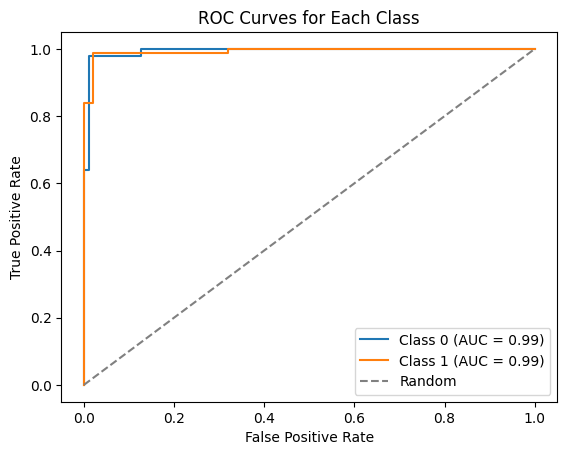

In [99]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_scores = model.predict(X_test)

# Compute ROC curves for each class
fprs = dict()
tprs = dict()
auc_scores = dict()

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_scores[:, i])
    fprs[i] = fpr
    tprs[i] = tpr
    auc_scores[i] = roc_auc_score(y_test[:, i], y_pred_scores[:, i])

# Plot ROC curves for each class and label with AUC score
plt.figure()
for i in range(y_test.shape[1]):
    plt.plot(fprs[i], tprs[i], label=f'Class {i} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curves for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


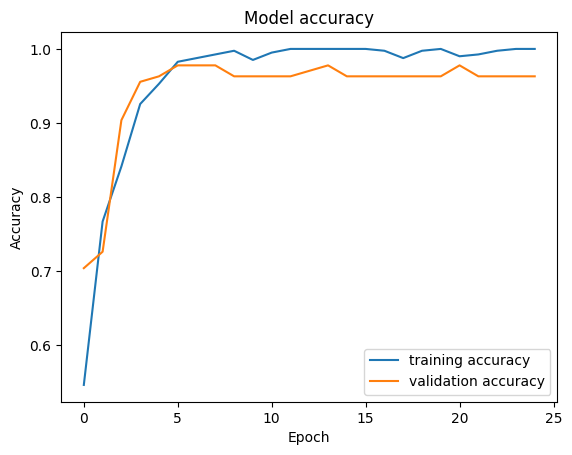

In [94]:
#Visualizing accuracy
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

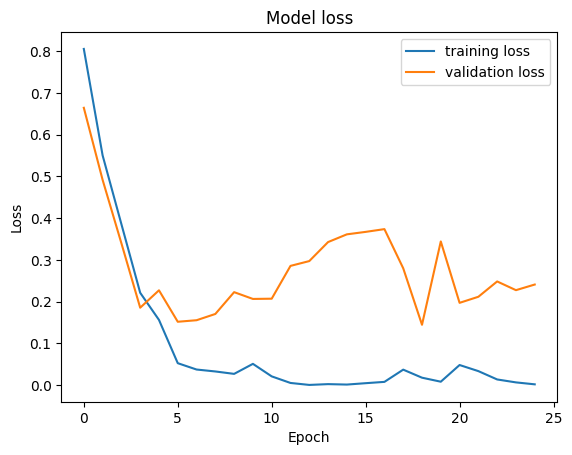

In [95]:
# Visualizing loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

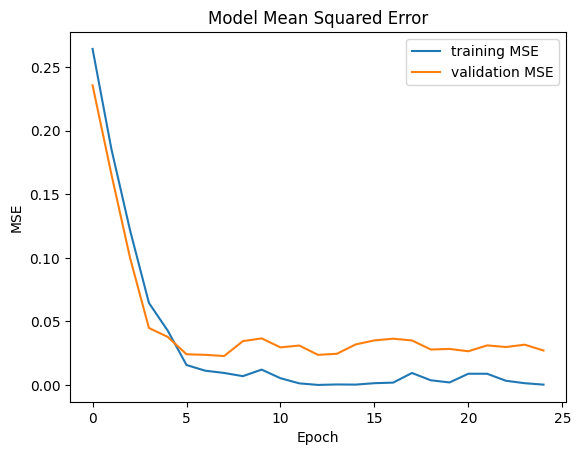

In [96]:
# Plot the MSE
plt.plot(history.history['mse'], label='training MSE')
plt.plot(history.history['val_mse'], label='validation MSE')
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()